**import the necessary**

In [16]:
from pathlib import Path
from tqdm import tqdm
from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
from collections import defaultdict
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np
import cv2
import torch, torchvision
import pandas as pd
import PIL.Image as Image
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import torch.nn.functional as F
import torchvision.transforms as T
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Import Dataset
**German Traffic Sign Recognition Benchmark**
More than 40 classes
More than 50,000 images in total

In [8]:
#https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#unzip -qq GTSRB_Final_Training_Images.zip

In [17]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))

#Analyse


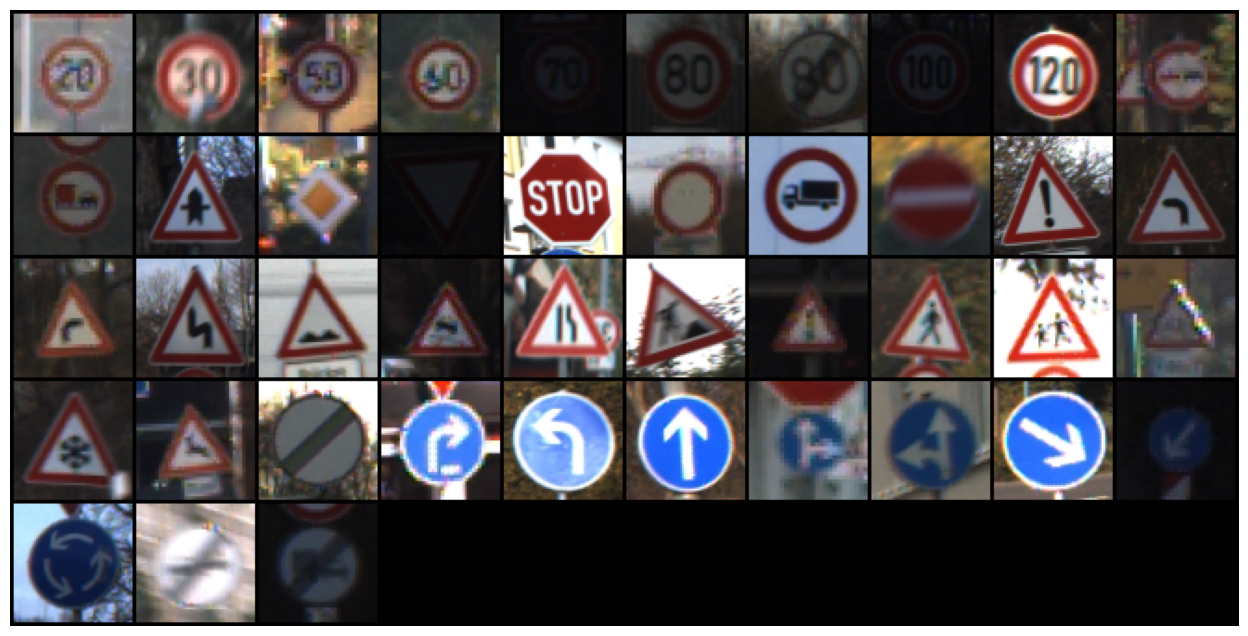

In [18]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    #redim_carre
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images=[]
  for path in image_paths:
    images.append(load_image(path))

  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=10)
  plt.figure(figsize=(16, 8))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

exemple_img=[]
for tf in train_folders:
  x=np.random.choice(glob(f'{tf}/*ppm'))
  exemple_img.append(x)
show_sign_grid(exemple_img)

#Building a dataset
**4 balanced class**


In [20]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [12, 13, 14, 17]

**priority road**

(28, 32, 3)


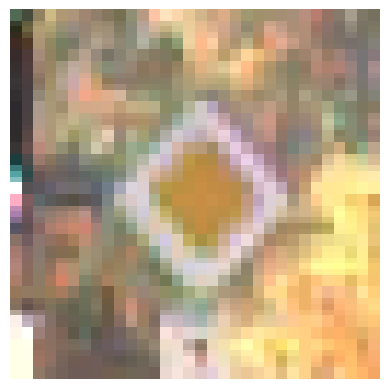

In [21]:
from PIL import Image
img_path = glob(f'{train_folders[12]}/*ppm')[31]

show_image(img_path)
img = cv2.imread(img_path)
dimensions = img.shape
print(dimensions)

**give_way**

(38, 38, 3)


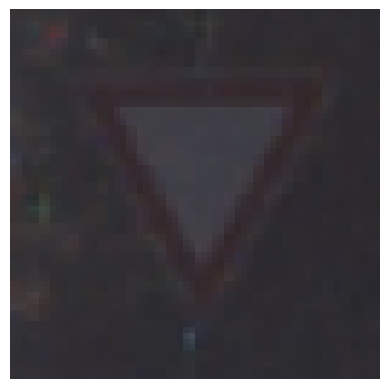

In [22]:
img_path = glob(f'{train_folders[13]}/*ppm')[13]

show_image(img_path)
img = cv2.imread(img_path)
dimensions = img.shape
print(dimensions)

**Stop**

(49, 51, 3)


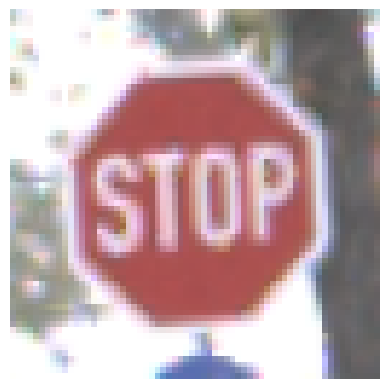

In [23]:
img_path = glob(f'{train_folders[14]}/*ppm')[3]

show_image(img_path)
img = cv2.imread(img_path)
dimensions = img.shape
print(dimensions)

**No entry**

(31, 30, 3)


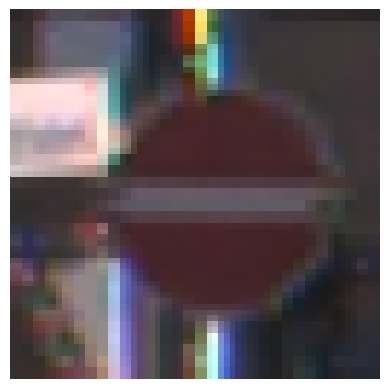

In [24]:
img_path = glob(f'{train_folders[17]}/*ppm')[100]

show_image(img_path)
img = cv2.imread(img_path)
dimensions = img.shape
print(dimensions)

In [25]:
#delete data folder
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)


for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)
  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )
  dataset_data = zip(DATASETS, ds_split)
  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


unbalanced dataset

In [26]:
for ds in DATASETS:
    for cls in class_names:
        image_paths = glob(f'{DATA_DIR}/{ds}/{cls}/*.ppm')
        num_images = len(image_paths)
        print(f'Dans le dossier {ds}, classe {cls} : {num_images} images.')

Dans le dossier train, classe priority_road : 1680 images.
Dans le dossier train, classe give_way : 1728 images.
Dans le dossier train, classe stop : 624 images.
Dans le dossier train, classe no_entry : 888 images.
Dans le dossier val, classe priority_road : 210 images.
Dans le dossier val, classe give_way : 216 images.
Dans le dossier val, classe stop : 78 images.
Dans le dossier val, classe no_entry : 111 images.
Dans le dossier test, classe priority_road : 210 images.
Dans le dossier test, classe give_way : 216 images.
Dans le dossier test, classe stop : 78 images.
Dans le dossier test, classe no_entry : 111 images.


split => 0.8 of the images for training, 0.1 for validation, and 0.1 test

#Data augmentation
**transformations**


In [27]:
def compute_mean_std(image_paths):

    mean_accumulator = np.zeros(3)
    std_accumulator = np.zeros(3)
    total_images = len(image_paths)

    for img_path in image_paths:

        img = Image.open(img_path)
        img = np.array(img) / 255.0

        mean_accumulator += np.mean(img, axis=(0, 1))
        std_accumulator += np.std(img, axis=(0, 1))

    mean_nums = mean_accumulator / total_images
    std_nums = std_accumulator / total_images

    return mean_nums, std_nums


mean_ds_split, std_ds_split = compute_mean_std(ds_split[0])

print("Moyenne pour l'ensemble d'entraînement (ds_split) :", mean_ds_split)
print("Écart-type pour l'ensemble d'entraînement (ds_split) :", std_ds_split)


Moyenne pour l'ensemble d'entraînement (ds_split) : [0.35647866 0.2848943  0.28621603]
Écart-type pour l'ensemble d'entraînement (ds_split) : [0.17970224 0.17157537 0.18059191]


In [28]:
mean_nums = [0.35724255, 0.28496815, 0.28595125]
std_nums = [0.1803585,  0.17152867, 0.18031636]
transforms1 = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])
, 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}


#Build datasets
DataLoader PyTorch (Normalisation +tensors)

In [29]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import uuid
import shutil
import os

# transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=256),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_nums, std_nums)
])


In [30]:
import random


underrepresented_classes = ['stop','give_way', 'priority_road', 'no_entry']


AUGMENTED_DATA_DIR = Path('augmented_data')
AUGMENTED_DATA_DIR.mkdir(parents=True, exist_ok=True)


num_augmented_images = 500


for cls in underrepresented_classes:
    class_dir = DATA_DIR / 'train' / cls
    images = list(class_dir.glob('*.ppm'))


    random.shuffle(images)
    selected_images = images[:num_augmented_images]


    augmented_class_dir = AUGMENTED_DATA_DIR / 'train' / cls
    augmented_class_dir.mkdir(parents=True, exist_ok=True)


    for img_path in selected_images:
        original_image = Image.open(img_path)
        augmented_image = train_transforms(original_image)

        augmented_image_pil = transforms.ToPILImage()(augmented_image)

        new_image_path = augmented_class_dir / (str(uuid.uuid4()) + '.ppm')
        augmented_image_pil.save(new_image_path)

    # Mélanger les images dans le répertoire augmenté
    augmented_images = list(augmented_class_dir.glob('*.ppm'))
    random.shuffle(augmented_images)
    for i, image_path in enumerate(augmented_images):
        new_image_path = augmented_class_dir / f'{i:04d}.ppm'
        image_path.rename(new_image_path)



Classe : stop, Nombre d'images augmentées : 500


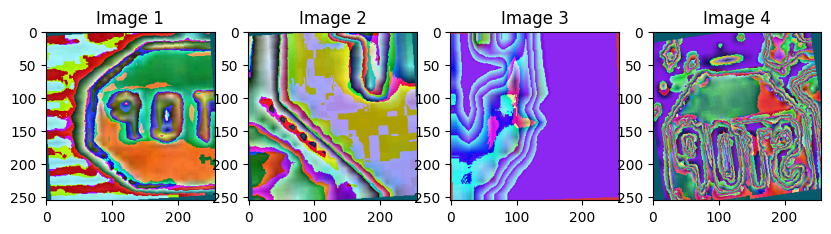

Classe : give_way, Nombre d'images augmentées : 500


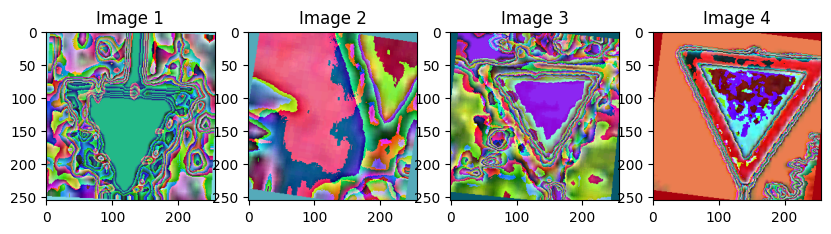

Classe : priority_road, Nombre d'images augmentées : 500


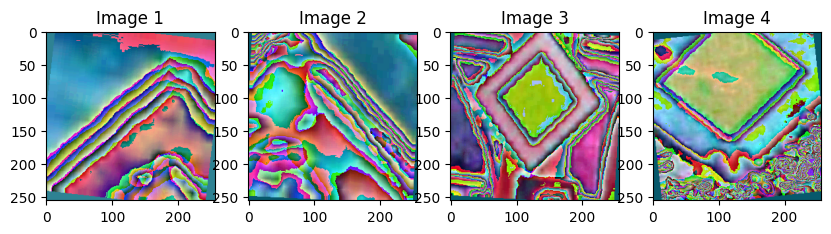

Classe : no_entry, Nombre d'images augmentées : 500


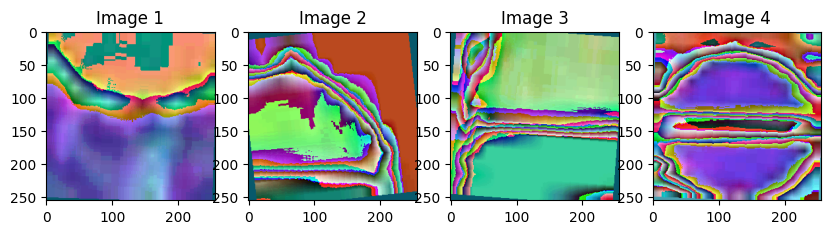

Classe : stop, Nombre total d'images augmentées : 500
Classe : give_way, Nombre total d'images augmentées : 500
Classe : priority_road, Nombre total d'images augmentées : 500
Classe : no_entry, Nombre total d'images augmentées : 500


In [31]:
import matplotlib.pyplot as plt

# Classes à examiner
classes_to_check = ['stop','give_way', 'priority_road', 'no_entry']


augmented_images_count = {}

for cls in classes_to_check:
    augmented_class_dir = AUGMENTED_DATA_DIR / 'train' / cls
    augmented_images = list(augmented_class_dir.glob('*.ppm'))

    # Compter le nombre d'images augmentées pour cette classe
    count = len(augmented_images)
    augmented_images_count[cls] = count

    # Afficher les images augmentées
    if count > 0:
        print(f"Classe : {cls}, Nombre d'images augmentées : {count}")
        plt.figure(figsize=(10, 10))
        for i in range(min(4, count)):
            image_path = augmented_images[i]
            img = Image.open(image_path)
            plt.subplot(1, 4, i+1)
            plt.imshow(img)
            plt.title(f"Image {i+1}")
        plt.show()

# Afficher le nombre total d'images augmentées pour chaque classe
for cls, count in augmented_images_count.items():
    print(f"Classe : {cls}, Nombre total d'images augmentées : {count}")


In [32]:
image_datasets = {}
data_loaders = {}

for d in DATASETS:
    chemin_dataset = f'{DATA_DIR}/{d}'
    image_datasets[d] = ImageFolder(chemin_dataset, transforms1[d])
    data_loaders[d] = DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=1)
    print(f"Taille  {d}: {len(data_loaders[d].dataset)} images")



Taille  train: 4920 images
Taille  val: 615 images
Taille  test: 615 images


In [33]:
images_count_par_classe_par_ensemble = {'train': {}, 'val': {}, 'test': {}}

# Parcourez les ensembles (train, val, test)
for d in DATASETS:
    ensemble = image_datasets[d]


    for classe, idx in ensemble.class_to_idx.items():

        nb_images_classe = len(ensemble.targets) - ensemble.targets.count(idx)
        images_count_par_classe_par_ensemble[d][classe] = nb_images_classe

# Affichez le nombre d'images par classe et par ensemble
for ensemble, classes in images_count_par_classe_par_ensemble.items():
    print(f"Ensemble : {ensemble}")
    for classe, count in classes.items():
        print(f"Classe : {classe}, Nombre d'images : {count}")

Ensemble : train
Classe : give_way, Nombre d'images : 3192
Classe : no_entry, Nombre d'images : 4032
Classe : priority_road, Nombre d'images : 3240
Classe : stop, Nombre d'images : 4296
Ensemble : val
Classe : give_way, Nombre d'images : 399
Classe : no_entry, Nombre d'images : 504
Classe : priority_road, Nombre d'images : 405
Classe : stop, Nombre d'images : 537
Ensemble : test
Classe : give_way, Nombre d'images : 399
Classe : no_entry, Nombre d'images : 504
Classe : priority_road, Nombre d'images : 405
Classe : stop, Nombre d'images : 537


In [34]:
from torchvision.datasets import ImageFolder


augmented_priority_road_dir = Path('/content/augmented_data/train/priority_road')
augmented_give_way_dir = Path('/content/augmented_data/train/give_way')


image_datasets['train'].class_to_idx.update({'priority_road': len(image_datasets['train'].classes) - 1, 'give_way': len(image_datasets['train'].classes) - 1})
image_datasets['train'].samples += [(path, len(image_datasets['train'].classes) - 1) for path in augmented_priority_road_dir.glob('*.ppm')]
image_datasets['train'].samples += [(path, len(image_datasets['train'].classes) - 1) for path in augmented_give_way_dir.glob('*.ppm')]


data_loaders['train'] = DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=1)





In [35]:
for d in DATASETS:
    ensemble = image_datasets[d]

    # Parcourez chaque classe
    for classe, idx in ensemble.class_to_idx.items():
        # Comptez le nombre d'images pour cette classe dans cet ensemble
        nb_images_classe = len(ensemble.targets) - ensemble.targets.count(idx)
        images_count_par_classe_par_ensemble[d][classe] = nb_images_classe

# Affichez le nombre d'images par classe et par ensemble
for ensemble, classes in images_count_par_classe_par_ensemble.items():
    print(f"Ensemble : {ensemble}")
    for classe, count in classes.items():
        print(f"Classe : {classe}, Nombre d'images : {count}")

Ensemble : train
Classe : give_way, Nombre d'images : 4296
Classe : no_entry, Nombre d'images : 4032
Classe : priority_road, Nombre d'images : 4296
Classe : stop, Nombre d'images : 4296
Ensemble : val
Classe : give_way, Nombre d'images : 399
Classe : no_entry, Nombre d'images : 504
Classe : priority_road, Nombre d'images : 405
Classe : stop, Nombre d'images : 537
Ensemble : test
Classe : give_way, Nombre d'images : 399
Classe : no_entry, Nombre d'images : 504
Classe : priority_road, Nombre d'images : 405
Classe : stop, Nombre d'images : 537


num_workers=nb processus (max=2)

In [36]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
print(dataset_sizes)

{'train': 4920, 'val': 615, 'test': 615}


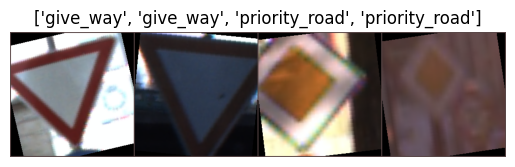

In [37]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


##Using a pre-trained model
 1- **Transfer Learning** from **ResNet101** model

In [38]:
import torch.nn as nn
import torchvision.models as models

def create_model(n_classes):
    # Load pre-trained ResNet-34 model
    model = models.resnet34(pretrained=True)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Modify the fully connected layer (classifier)
    model.fc.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, n_classes)

    return model.to(device)


 instance of the model:

In [39]:
base_model = create_model(len(class_names))

c:\Users\Guide Info\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Guide Info\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##Training


In [42]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  scheduler.step()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=10):
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')

  model.load_state_dict(torch.load('best_model_state.bin'))
  return model, history

In [45]:
%%time
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.6779187374649858 accuracy 0.7390243902439024
Val   loss 0.33300933878651107 accuracy 0.865040650406504

Epoch 2/10
----------
Train loss 0.5097642991108805 accuracy 0.8085365853658537
Val   loss 0.15864305135751652 accuracy 0.959349593495935

Epoch 3/10
----------
Train loss 0.5089715698590063 accuracy 0.808130081300813
Val   loss 0.14878597585242484 accuracy 0.9544715447154472

Epoch 4/10
----------
Train loss 0.4655633602802437 accuracy 0.8264227642276423
Val   loss 0.16338961437426194 accuracy 0.9495934959349593

Epoch 5/10
----------
Train loss 0.45901625465442675 accuracy 0.8282520325203252
Val   loss 0.15771938208263828 accuracy 0.9495934959349593

Epoch 6/10
----------
Train loss 0.46123439399345695 accuracy 0.8280487804878048
Val   loss 0.15275381089266776 accuracy 0.9528455284552846

Epoch 7/10
----------
Train loss 0.45197382050933604 accuracy 0.8345528455284553
Val   loss 0.14499189450130376 accuracy 0.9544715447154472

Epoch 8/10
---------

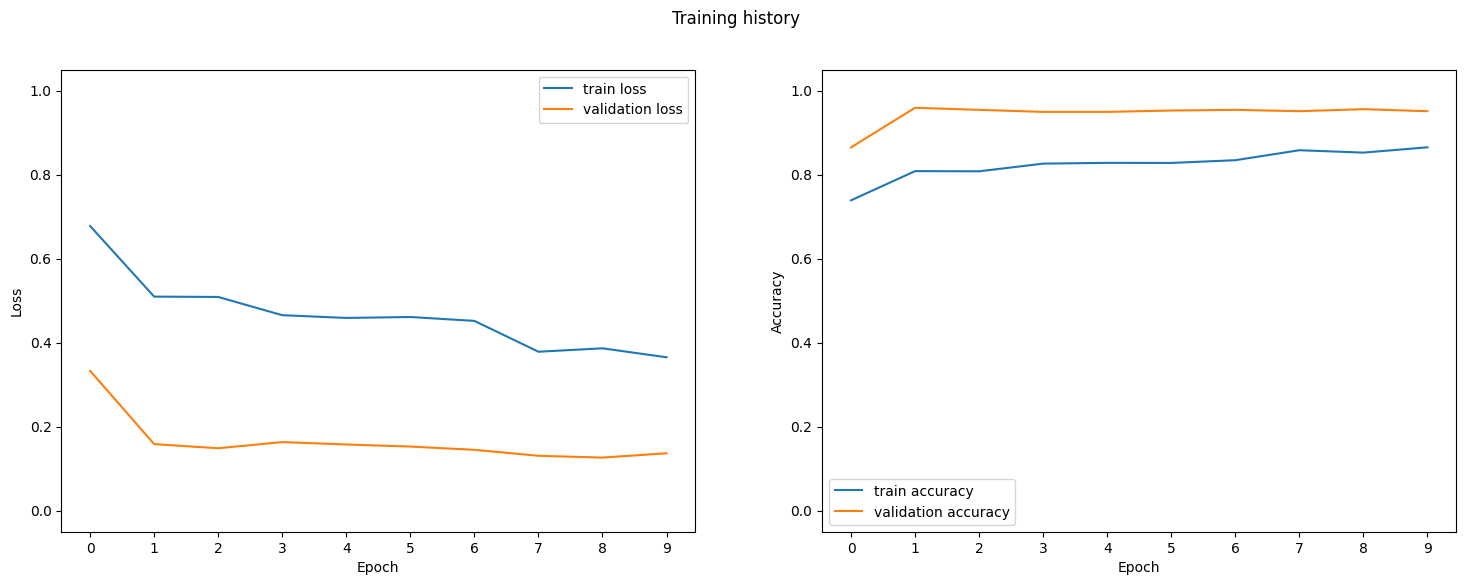

In [46]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  train_loss = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in history['train_loss']]
  val_loss = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in history['val_loss']]
  train_acc = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in history['train_acc']]
  val_acc = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in history['val_acc']]

  ax1.plot(train_loss, label='train loss')
  ax1.plot(val_loss, label='validation loss')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(train_acc, label='train accuracy')
  ax2.plot(val_acc, label='validation accuracy')
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

plot_training_history(history)



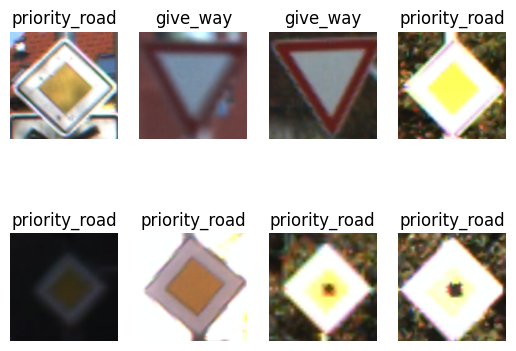

In [47]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'{class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return
show_predictions(base_model, class_names, n_images=8)

In [48]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(base_model, data_loaders['test'])
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       0.98      0.95      0.96       216
     no_entry       1.00      0.92      0.96       111
priority_road       0.90      0.99      0.95       210
         stop       0.99      0.92      0.95        78

     accuracy                           0.95       615
    macro avg       0.97      0.95      0.95       615
 weighted avg       0.96      0.95      0.95       615



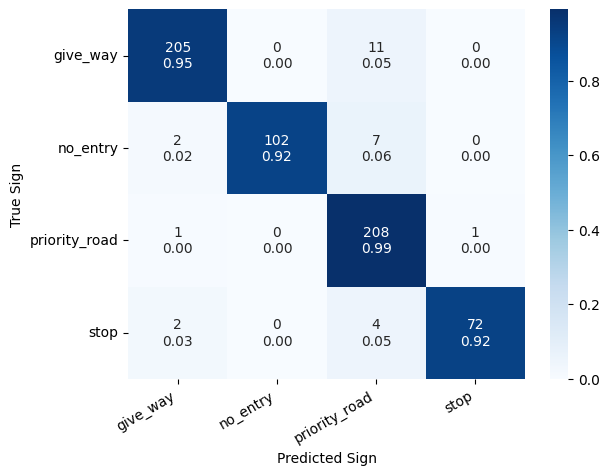

In [49]:
def show_confusion_matrix(confusion_matrix, class_names):
  cm = confusion_matrix.copy()
  cell_counts = cm.flatten()
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

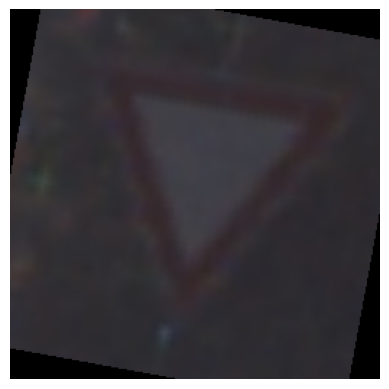

In [50]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
img_path = glob(f'{train_folders[13]}/*ppm')[13]
image = Image.open(img_path)
show_image(img_path)
transforms_test = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(degrees=30)
])

transformed_image = transforms_test(image)


plt.imshow(transformed_image)
plt.show()

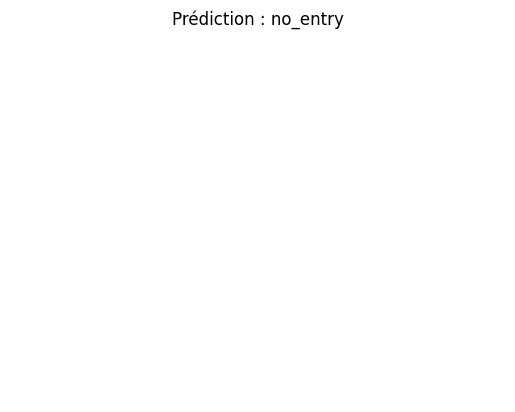

In [51]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def pil_to_tensor(image):
    image = np.array(image)
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    return image.unsqueeze(0)

def show_single_image_prediction(model, transformed_image, class_names, device):
    model = model.eval()

    transformed_image = pil_to_tensor(transformed_image).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        _, preds = torch.max(output, 1)

    plt.figure()
    ax = plt.gca()
    ax.set_title(f'Prédiction : {class_names[preds[0].item()]}')

    ax.axis('off')
    plt.show()


show_single_image_prediction(base_model, transformed_image, class_names, device)


